<a href="https://colab.research.google.com/github/jermwatt/machine_learning_refined/blob/main/notes/5_Linear_regression/5_6_Multi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter 5: Linear regression

# Multi-Output Regression

Thus far we have assumed that datapoints for linear regression consist of $N$ dimensional *vector valued* inputs and *scalar-valued* outputs.  That is, a prototypical datapoint takes the form  $\left(\mathbf{x}_p,\,y_p\right)$ where $\mathbf{x}_p$ is an $N$ dimensional *input vector* and a $y_p$ is a *scalar* output.  While this configuration covers the vast majority of regression cases one may well encounter in practice, it is possible to perform (linear) regression where both *input* and *output* are *vector-valued*.  This is often called *multiple-output regression*, and in this Section we describe how to extend the basic elements of this Chapter to properly handle it.

In [1]:
# import standard libs
import os

# if on collab pull required subdirectories
if os.getenv("COLAB_RELEASE_TAG"): 
    # install github clone - allows for easy cloning of subdirectories
    !pip install github-clone
    from pathlib import Path 

    # clone datasets
    if not Path('chapter_5_datasets').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/5_Linear_regression/chapter_5_datasets
    else:
        print('chapter_5_datasets already cloned!')

    # clone library subdirectory
    if not Path('chapter_5_library').is_dir():
        !ghclone https://github.com/jermwatt/machine_learning_refined/tree/main/notes/5_Linear_regression/chapter_5_library
    else:
        print('chapter_5_library already cloned!')

# append path for local library, data, and image import
import sys
sys.path.append('./chapter_5_library')
sys.path.append('./chapter_5_datasets') 

# import section helper
import section_5_6_helpers

# dataset paths
data_path_1 = 'chapter_5_datasets/linear_2output_regression.csv'

# standard imports
import matplotlib.pyplot as plt

# import autograd-wrapped numpy
import autograd.numpy as np

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=40b83eb64600263c42853a300beb5e7b2295636ba352b165e8ecb8b7260a03b5
  Stored in directory: /root/.cache/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built docopt
Cloning into 'chapter_5_datasets'...
done.
Cloning into 'chapter_5_library'...
done.


##  Notation and modeling

Suppose now that instead of being *scalar-valued* the output of a regression dataset were *vector-valued*.  That is our datapoints 

\begin{equation}
 \left(\mathbf{x}_{1}^{\,},\mathbf{y}_{1}^{\,}\right),\,\left(\mathbf{x}_{2}^{\,},\mathbf{y}_{2}^{\,}\right),\,...,\,\left(\mathbf{x}_{P}^{\,},\mathbf{y}_{P}^{\,}\right)
\end{equation}

have both *vector-valued* input *and* output.  The $p^{th}$ point $\left(\mathbf{x}_{p}^{\,},\mathbf{y}_{p}^{\,}\right)$ has $N$ dimensional input $\mathbf{x}_p$ and associated $C$ dimensional output $\mathbf{y}_p$.  While in principle we can treat $\mathbf{y}_p$ as a $C \times 1$ column vector, in order to keep the formulae that follows looking similar to what we have already seen in the scalar case we will treat the *input* as a $N\times 1$ *column* vector and the output as a $1 \times C$ *row* vector as

\begin{equation}
\mathbf{x}_{p}=\begin{bmatrix}
x_{1,p}\\
x_{2,p}\\
\vdots\\
x_{N,p}
\end{bmatrix}  \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,  \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,  
\mathbf{y}_{p}=\begin{bmatrix}
y_{0,p} &
y_{1,p} &
\cdots &
y_{C-1,p}
\end{bmatrix}.
\end{equation}

Notice that we index the *output* dimension of $\mathbf{y}_p$ from $j = 0,1,...,C-1$, starting from $0$ instead of $1$ as with the *input* dimension of $\mathbf{x}_p$ which ranges from $n = 1,...,N$.  We do this because we will stack a $1$ on top of each input point $\mathbf{x}_p$ (as shown below) and this entry will have the $0^{th}$ index of our input.

Now, notice that to suppose that a *linear* relationship holds between the input $\mathbf{x}_p$ and *just* the scalar-valued $c^{th}$ dimension of the output $y_{c,p}$ of such a dataset results in precisely the sort of regression framework we have seen thus far.  That is if we denote

\begin{equation}
\mathbf{w}_c=\begin{bmatrix}
w_{0,c}\\
w_{1,c}\\
w_{2,c}\\
\vdots\\
w_{N,c}
\end{bmatrix}
\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,
\mathring{\mathbf{x}}_p=\begin{bmatrix}
1 \\
x_{1,p}\\
x_{2,p}\\
\vdots\\
x_{N,p}
\end{bmatrix},\,\,\,\, p = 1,...,P
\end{equation}

where $\mathbf{w}_c$ is a set of weights then - if these are tuned properly - the assumption of a linear relationship looks like precisely what we have seen starting in [Section 5.1](https://jermwatt.github.io/machine_learning_refined/notes/5_Linear_regression/5_2_Least.html)
 
\begin{equation}
\mathring{\mathbf{x}}_{p}^T  \overset{\,}{\mathbf{w}}_{c}^{\,}    \approx \overset{\,}{y}_{c,p}^{\,} \,\,\,\,\,\,\,\,\,\,\,    \,\,\,\,\,\,\,\,\,\,\, p=1,...,P.
\end{equation}

Then let us suppose that a linear relationship holds between the input and all $C$ entries of the output.  If we place each weight vector $\mathbf{w}_c$ into the $c^{th}$ column of the $\left(N+1\right) \times C$ *weight matrix* $\mathbf{W}$ as

\begin{equation}
\mathbf{W}=\begin{bmatrix} 
w_{0,0}  &  w_{0,1}  &  w_{0,2}  & \cdots   &  w_{0,C-1}  \\
w_{1,0}  &  w_{1,1}  &  w_{1,2}  & \cdots  &   w_{1,C-1}  \\
w_{2,0}  &  w_{2,1}  &  w_{2,2}  & \cdots  &  w_{2,C-1}  \\
\,\,\, {\vdots}_{\,\,\,}  & {\vdots}_{\,\,\,}  &  {\vdots}_{\,\,\,}  &  \cdots   &    {\vdots}_{\,\,\,}    \\
w_{N,0}  &  w_{N,1} & w_{N,2}  &  \cdots  &  w_{N,C-1}  \\
\end{bmatrix}
\end{equation}

then the entire set of $C$ linear models can be written compactly as $1\times C$ vector-matrix product

\begin{equation}
\begin{matrix}  \mathring{\mathbf{x}}_p^T\mathbf{W} \end{matrix}  = \begin{bmatrix}
\mathring{\mathbf{x}}_p^T  \overset{\,}{\mathbf{w}}_{0}^{\,}   &
\mathring{\mathbf{x}}_p^T  \overset{\,}{\mathbf{w}}_{1}^{\,}   &
\cdots \, &
\mathring{\mathbf{x}}_p^T  \overset{\,}{\mathbf{w}}_{C-1}^{\,}
\end{bmatrix}
\end{equation}

and then the entire set of $C$ linear relationships can likewise be written as 

\begin{equation}
\mathring{\mathbf{x}}_{p}^T  \overset{\,}{\mathbf{W}}_{\,}^{\,}    \approx \overset{\,}{\mathbf{y}}_{p}^{\,} \,\,\,\,\,\,\,\,\,\,\,    \,\,\,\,\,\,\,\,\,\,\, p=1,...,P.
\end{equation}

But of course this approximation $\approx$ only truly holds if we can tune the weights $\mathbf{W}$ properly.  To do this we can invoke any regression cost function - e.g., the Least Squares or Least Absolute Deviations - and properly minimize in order to make this approximation hold as well as possible.

## Cost functions

The thought process involved in deriving a regression cost function for the case of multi-output regression mirrors almost exactly the scalar-output case discussed in Sections [5.2](https://jermwatt.github.io/machine_learning_refined/notes/5_Linear_regression/5_2_Least.html) and [5.3](https://jermwatt.github.io/machine_learning_refined/notes/5_Linear_regression/5_3_Absolute.html).  For example, to derive a Least Squares cost function we begin by taking the difference of both sides in equation (6) above.  However now the error associated with the $p^{th}$ point, written as $\mathring{\mathbf{x}}_{p}^T  \overset{\,}{\mathbf{W}}_{\,}^{\,}    - \overset{\,}{\mathbf{y}}_{p}^{\,}$, has $C$ values.  To square this error we must employ the *squared* $\ell_2$ norm, which is a natural extension of the squaring operation $\left(\cdot\right)^2$ to vectors (described further in Appendix Section).  The Least Squares cost function in this case is then the average of the $\ell_2$ norm of each point's error as

\begin{equation}
 g\left(\mathbf{W}\right) = \frac{1}{P}\sum_{p=1}^{P} \left \Vert \mathring{\mathbf{x}}_{p}^T  \overset{\,}{\mathbf{W}}_{\,}^{\,}    - \overset{\,}{\mathbf{y}}_{p}^{\,} \right \Vert_2^2 = \frac{1}{P}\sum_{p=1}^{P} \sum_{c=0}^{C-1} \left( \mathring{\mathbf{x}}_{p}^T  \overset{\,}{\mathbf{w}}_{c}^{\,}   - \overset{\,}{y}_{c,p}^{\,}   \right)^2
\end{equation}

When the output takes on scalar value, that is when $C=1$, this reduces to the Least Squares cost we saw in [Section 5.2](https://jermwatt.github.io/machine_learning_refined/notes/5_Linear_regression/5_2_Least.html).

Likewise the analagous Least Absolute Deviations (which measures the absolute value of each error as opposed to its square) cost for our present case takes the form

\begin{equation}
 g\left(\mathbf{W}\right) = \frac{1}{P}\sum_{p=1}^{P} \left \Vert \mathring{\mathbf{x}}_{p}^T  \overset{\,}{\mathbf{W}}_{\,}^{\,}    - \overset{\,}{\mathbf{y}}_{p}^{\,} \right \Vert_1 = \frac{1}{P}\sum_{p=1}^{P} \sum_{c=0}^{C-1} \left\vert \mathring{\mathbf{x}}_{p}^T  \overset{\,}{\mathbf{w}}_{c}^{\,}   - \overset{\,}{y}_{c,p}^{\,}   \right\vert
\end{equation}

where $\left\Vert \cdot \right \Vert_1$ is the $\ell_1$ norm, the generalization of the absolute value function for vectors (see the Appendix Section for further information).

These cost functions - like their scalar-valued output analogs described are alwasy convex *regardless of the dataset used*.  

They also *decompose over the weights $\mathbf{w}_c$ associated with each output dimension*.  For example, notice that we can rewrite the right hand side of the Least Absolute Deviations cost above by swpping the summands over $P$ and $C$ giving

\begin{equation}
 g\left(\mathbf{W}\right) =  \sum_{c=0}^{C-1} \left(\frac{1}{P}\sum_{p=1}^{P} \left\vert \mathring{\mathbf{x}}_{p}^T  \overset{\,}{\mathbf{w}}_{c}^{\,}   - \overset{\,}{y}_{c,p}^{\,}   \right\vert\right)  =  \sum_{c=0}^{C-1} g_c\left(\mathbf{w}_c\right)
\end{equation}

where we have denoted $g_c\left(\mathbf{w}_c\right) = \frac{1}{P}\sum_{p=1}^{P} \left\vert \mathring{\mathbf{x}}_{p}^T  \overset{\,}{\mathbf{w}}_{c}^{\,}   - \overset{\,}{y}_{c,p}^{\,}   \right\vert$.  Since the weights from each of the $C$ problems do not interact we can if desired minimize each $g_c$ for an optimal setting of $\mathbf{w}_c$ independently, and then take their sum to form the full cost function $g$.

##  Implementing cost functions in `Python`

Because `Python` has such flexible sytax, we can implement the linear model

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{W}\right) =
\mathring{\mathbf{x}}^T\mathbf{W}^{\,} 
\end{equation}

precisely as we have done before.  In *implementing* this linear combination we need not form the adjusted input $\mathring{\mathbf{x}}_{p}$ (by tacking a $1$ on top of the raw input $\mathbf{x}_p$) and can more easily compute the linear combination by exposing the biases as


\begin{equation}
\mathring{\mathbf{x}}_{p}^T \mathbf{W} = \mathbf{b} + \mathbf{x}_p^T \mathbf{\mathcal{W}}
\end{equation}

Here we use the following bias / feature weight notation


\begin{equation}
\text{(biases):}\,\, \mathbf{b} = \begin{bmatrix} w_{0,0} \\ w_{0,1} \\ w_{0,2} \\ \vdots \\ w_{0,C-1} \end{bmatrix}
\,\,\, \text{(feature-touching weights):} \,\,\,\,\,\, \boldsymbol{\mathcal{W}}
=\begin{bmatrix} 
w_{0,1}  &  w_{0,2}  & \cdots   &  w_{0,C-1}  \\
w_{1,1}  &  w_{1,2}  & \cdots  &   w_{1,C-1}  \\
w_{2,1}  &  w_{2,2}  & \cdots  &  w_{2,C-1}  \\
\,\,\, {\vdots}_{\,\,\,}  & {\vdots}_{\,\,\,}  &  {\vdots}_{\,\,\,}   &    {\vdots}_{\,\,\,}    \\
w_{N,1} & w_{N,2}  &  \cdots  &  w_{N,C-1}  \\
\end{bmatrix}.
\end{equation}

This notation is used to match the `Pythonic` slicing operation (as shown in the implementation given below), which we implement in `Python` analagously as

                            a = w[0] + np.dot(x_p.T,w[1:])

That is $\mathbf{b} = w[0]$ denotes the bias and $\mathbf{\mathcal{W}} = w[1:]$ denotes the remaining feature-touching.  Another reason to implement in this way is that the particular linear combination $\mathbf{x}_p^T \mathbf{\mathcal{W}}_{\,}^{\,}$ - implemented using `np.dot` as `np.dot(x_p.T,w[1:])` below - is an especially effecient since `numpy`'s `np.dot` operation is far more effecient than constructing a linear combination in `Python` via an explicit `for` loop.

In [2]:
# compute linear combination of input points
def model(x,w):
    a = w[0] + np.dot(x.T,w[1:])
    return a.T

`Pythonic` implementation of regression cost functions can also be implemented precisely as we have seen previously.  For example, the Least Squares cost can be written as shown below.

In [3]:
# an implementation of the least squares cost function for linear regression
def least_squares(w):    
    # compute the least squares cost
    cost = np.sum((model(x,w) - y)**2)
    return cost/float(np.size(y))

#### <span style="color:#a50e3e;">Example 1: </span> Fitting a linear model to a multi-output regression dataset

In this example we show an example of multi-output linear regression using a toy dataset with input dimension $N=2$ and output dimension $C=2$.  The dataset is shown below.

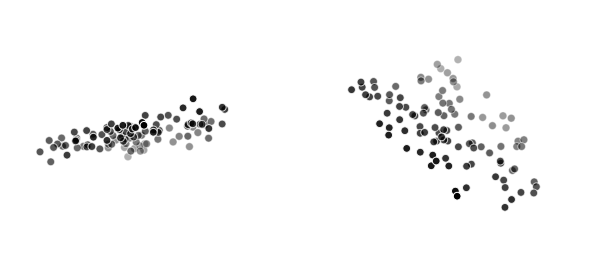

In [4]:
# load in data
data = np.loadtxt(data_path_1, delimiter=',')
x = data[:2,:]
y = data[2:,:]

# plot
view1 = [20,40]; view2 = [20,40]
section_5_6_helpers.plot_data(x,y,view1,view2)

We use the `Pythonic` Least Squares function shown above, minimizing it using $200$ steps of gradient descent using a steplength / learning rate $\alpha = 1$.  The cost function history from this run is shown below.

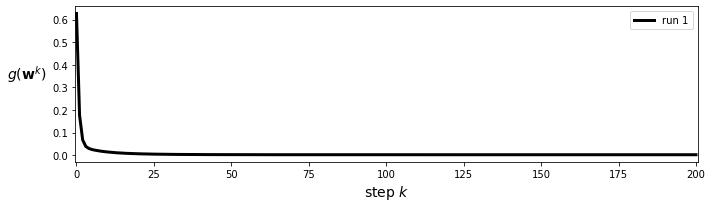

In [5]:
# setup and run optimization
g = least_squares; 
w = 0.1*np.random.randn(3,2)
max_its = 200;
alpha_choice = 1;
weight_history,cost_history = section_5_6_helpers.gradient_descent(g,alpha_choice,max_its,w)

# plot history
section_5_6_helpers.static_visualizer().plot_cost_histories([cost_history],start = 0,points = False,labels = ['run 1'])

Using the fully trained model from this run of gradient descent we evaluate a fine mesh of points in the region over which the input of this dataset is defined to visualize our linear approximations.  These are shown in light green in the panels below.

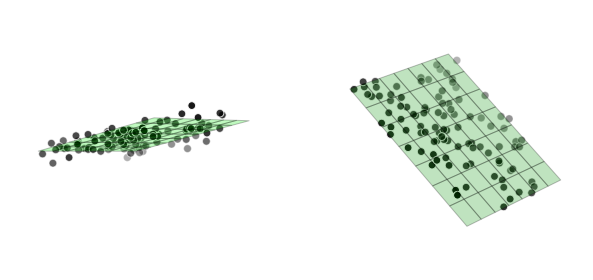

In [6]:
# determine best weights - based on lowest cost value attained
ind = np.argmin(cost_history)
w_best = weight_history[ind]

# form predictor
predictor = lambda x: model(x,w_best)

# plot data with predictions
view1 = [20,40]; view2 = [20,40]
section_5_6_helpers.plot_regressions(x,y,predictor,view1,view2)